In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'selectivity_JSB'

In [5]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [6]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [33]:
all_animals = 'c3m1', 'c3m2','c10m6','c10m8','c3f3',#'90','90_475', '91','93_500','93_580','93_720','93_810',
pre_animals = 'c3m1', 'c3m2','c10m6','c10m8','c3f3'
post_animals ='c3m1', 'c3m2','c10m6','c10m8','c3f3',#'90','90_475', '91','93_500','93_580','93_720','93_810'

In [34]:
sessions = 'pre', 'post'

In [35]:
for sess in 'pre', 'post':
    exec('selectivity_%s = {}'%sess)
    for ani in eval('%s_animals'%sess):
        try:
            eval('selectivity_%s'%sess).update({ani: ut.load_variable('selectivity', '../%s/%s/notebooks/autorestore/selectivity_JSB/'%(ani, sess))})
        except IOError:
            continue

In [36]:
stims = ['rewardt', 'rewardt_tr', 'rewardt_us', 'rewardt_licks', 'CSmt', 'CSmt_tr', 'CSmt_us',
        'STIM1t', 'STIM1t_tr', 'STIM1t_us',
        'STIM2t', 'STIM2t_tr', 'STIM2t_us',
        'STIM3t', 'STIM3t_tr', 'STIM3t_us',
        'STIM4t', 'STIM4t_tr', 'STIM4t_us']

In [37]:
def extract_pos_neg(selectivity, mice, significance=0.05,
                    odors=None):
    
    if odors is None:
        odors = stims

    posmods = {}
    negmods = {}

    for mouse in mice:
        try:
            posmods[mouse] = []
            negmods[mouse] = []
            sel = selectivity[mouse]
    #         print sel
            n_cells = len(selectivity[mouse])
            for od in odors:
                dirs = [s[1] for s in sel[od]]
                pvals = [s[0][1] for s in sel[od]]
                posmods[mouse].append(np.mean([d>0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))]))
                negmods[mouse].append(np.mean([d<0 and p<significance
                                                 for d, p in zip(dirs, ut.adjust_pvalues(pvals))])) 
        except KeyError as error:
            print "No data for %s (%s)." % (mouse, odors)
            print 'KeyError = ', error
            posmods[mouse] = [np.nan]*len(odors)
            negmods[mouse] = [np.nan]*len(odors)
    return posmods, negmods

In [38]:
pos_pre, neg_pre = extract_pos_neg(selectivity_pre, pre_animals)
pos_post, neg_post = extract_pos_neg(selectivity_post, post_animals)

In [39]:
def plot_it(animals, pos_all, neg_all, with_dots=False, which_odors=None, figsize=(4, 2)):
    
    fig, ax = pl.subplots(1, 1, figsize=figsize)

    if which_odors is None:
        which_odors = range(len(stims))
    
    pos = {k:v for k, v in pos_all.iteritems() if k in animals}
    neg = {k:v for k, v in neg_all.iteritems() if k in animals}

    for i, w in enumerate(which_odors):
        vals = np.r_[pos.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]-0.05, vals, 'o', ms=3, color='k', mew=0, alpha=0.3)
        ax.plot([i-0.2-0.05, i+0.2-0.05], [vals.mean()]*2, color='k', alpha=1)
        ax.errorbar(i-0.05, vals.mean(), sstats.sem(vals), lw=1, color='k')
        vals = -np.r_[neg.values()][:, w]*100
        vals = vals[~np.isnan(vals)]
        if with_dots:
            ax.plot(np.r_[[i]*len(vals)]+0.05, vals, 'o', ms=3, color='C0', mew=0, alpha=0.3)
        ax.plot([i-0.2+0.05, i+0.2+0.05], [vals.mean()]*2, color='C0', alpha=1)
        ax.errorbar(i+0.05, vals.mean(), sstats.sem(vals), lw=1, color='C0')

    ax.set_xticks(range(len(which_odors)))
    ax.set_xticklabels(stims, fontsize=5, rotation=60)

    #     ax.set_xlabel('Odor')
    pt.nicer_plot(ax)
    # ax.set_ylim(-.1, .5)
    ax.hlines(0, -.5, len(which_odors), color='0.8', linestyles='dotted', lw=1)

    ax.set_ylabel('Percentage of\nResponding Neurons', fontsize=5)

    ax.set_ylim(-18, 80)

    # pl.savefig('../img/selectivity_prepost.pdf')
    return fig, ax
    

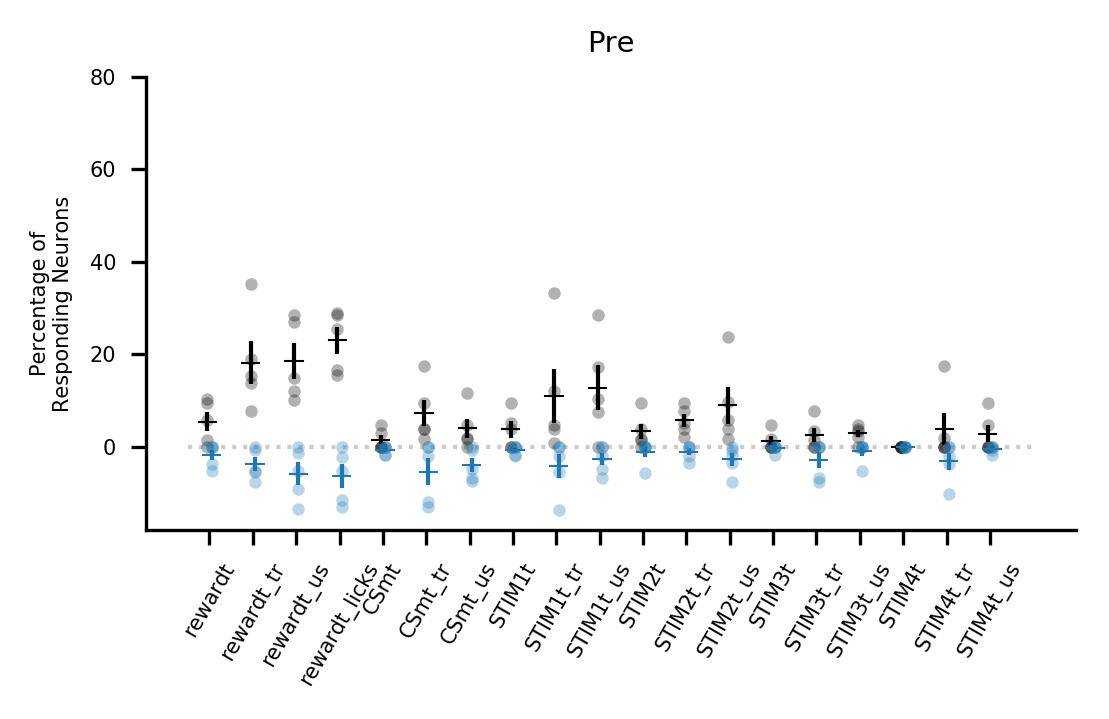

In [40]:
fig, ax = plot_it(pre_animals, pos_pre, neg_pre, with_dots=True)
ax.set_title('Pre', fontsize=7)
fig.savefig('../img/selectivity_pre.pdf', bbok='tight')

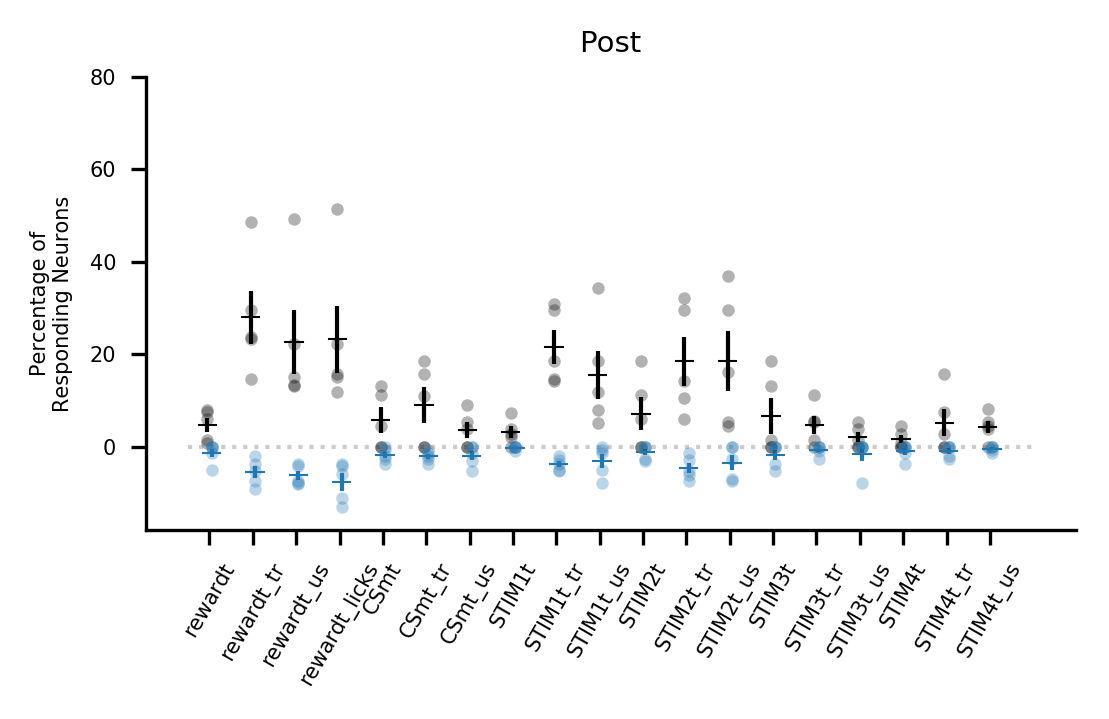

In [41]:
fig, ax = plot_it(post_animals, pos_post, neg_post, with_dots=True)
ax.set_title('Post', fontsize=7)
fig.savefig('../img/selectivity_post.pdf', bbok='tight')

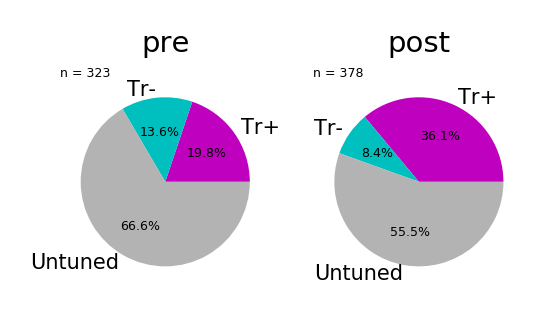

In [42]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['csp'] = np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['rewardt_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['csm'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['CSmt_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))

fig, axs = pl.subplots(1, 2, figsize=(2, 1))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['csp'].sum()/len(eval("pvs_%s"%sess)['csp']),
           1.*eval("pvs_%s"%sess)['csm'].sum()/len(eval("pvs_%s"%sess)['csp']),
           1.*(~(eval("pvs_%s"%sess)['csm']+eval("pvs_%s"%sess)['csp'])).sum()/len(eval("pvs_%s"%sess)['csp'])],
           colors=['m', 'c', '0.7'], labels=['Tr+', 'Tr-', 'Untuned'], autopct=lambda x: "%.1f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['csp'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


fig.savefig('../img/%s_Tr_pies_combined.pdf'%NOTEBOOK_NAME, bbox='tight')

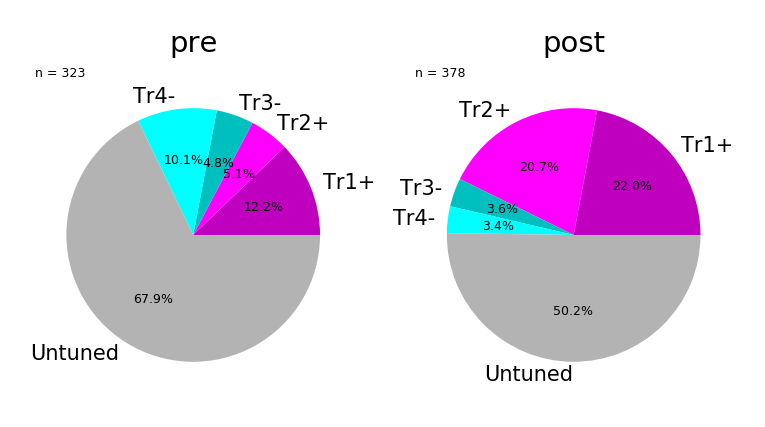

In [43]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['STIM1'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM1t_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM2'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM2t_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM3'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM3t_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM4'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM4t_tr']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))

fig, axs = pl.subplots(1, 2, figsize=(3, 1.5))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['STIM1'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM2'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM3'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM4'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*(~(eval("pvs_%s"%sess)['STIM1']+eval("pvs_%s"%sess)['STIM2']+eval("pvs_%s"%sess)['STIM3']+eval("pvs_%s"%sess)['STIM4'])).sum()/len(eval("pvs_%s"%sess)['STIM1'])],
           colors=['m', 'fuchsia','c','cyan', '0.7'], labels=['Tr1+', 'Tr2+','Tr3-','Tr4-', 'Untuned'], autopct=lambda x: "%.1f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['STIM1'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


fig.savefig('../img/%s_Tr_pies_individ.pdf'%NOTEBOOK_NAME, bbox='tight')

# above are trace period for all cells (not just cell reg)

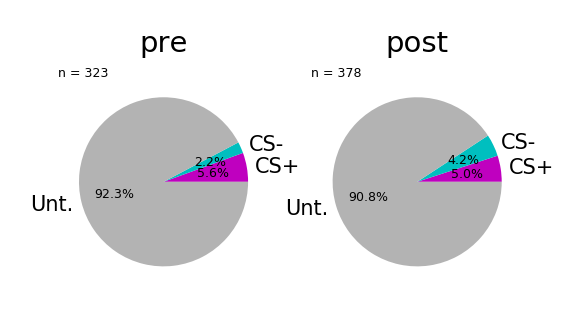

In [44]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['csp'] = np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['rewardt']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['csm'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['CSmt']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))

fig, axs = pl.subplots(1, 2, figsize=(2, 1))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['csp'].sum()/len(eval("pvs_%s"%sess)['csp']),
           1.*eval("pvs_%s"%sess)['csm'].sum()/len(eval("pvs_%s"%sess)['csp']),
           1.*(~(eval("pvs_%s"%sess)['csm']+eval("pvs_%s"%sess)['csp'])).sum()/len(eval("pvs_%s"%sess)['csp'])],
           colors=['m', 'c', '0.7'], labels=['CS+', 'CS-', 'Unt.'], autopct=lambda x: "%.1f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['csp'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


fig.savefig('../img/%s_CS_pies_combined.pdf'%NOTEBOOK_NAME, bbox='tight')

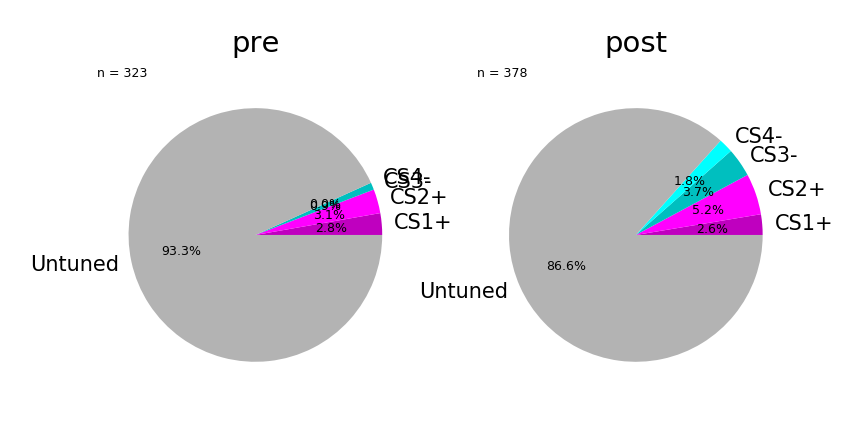

In [45]:
pvalue = 0.05
for sess in sessions:
    
    exec("pvs_%s = {}"%sess)
    exec("pvs_%s['STIM1'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM1t']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM2'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM2t']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM3'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM3t']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))
    exec("pvs_%s['STIM4'] =  np.concatenate([ut.adjust_pvalues([s[0][-1] for s in selectivity_%s[ani]['STIM4t']])<pvalue\
                                     for ani in %s_animals])"%(sess, sess, sess))

fig, axs = pl.subplots(1, 2, figsize=(3, 1.5))

for sess, ax in zip(sessions, axs):
    
    p = ax.pie([1.*eval("pvs_%s"%sess)['STIM1'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM2'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM3'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*eval("pvs_%s"%sess)['STIM4'].sum()/len(eval("pvs_%s"%sess)['STIM1']),
           1.*(~(eval("pvs_%s"%sess)['STIM1']+eval("pvs_%s"%sess)['STIM2']+eval("pvs_%s"%sess)['STIM3']+eval("pvs_%s"%sess)['STIM4'])).sum()/len(eval("pvs_%s"%sess)['STIM1'])],
           colors=['m', 'fuchsia','c','cyan', '0.7'], labels=['CS1+', 'CS2+','CS3-','CS4-', 'Untuned'], autopct=lambda x: "%.1f%%"%(x))

    ax.set_title(sess)
    for pp in p[1]:
        pp.set_fontsize(5)
    for pp in p[2]:
        pp.set_fontsize(3)
        
    ax.text(0, 1, "n = %d"%(len(eval("pvs_%s"%sess)['STIM1'])), transform=ax.transAxes, fontsize=3)
    
    ax.set_aspect('equal')


fig.savefig('../img/%s_CS_pies_individ.pdf'%NOTEBOOK_NAME, bbox='tight')

In [46]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
